# Real vs. Alt-Baltimore: Neighborhood Comparison

This notebook compares the Alt-Baltimore worldbuild polygons to official
Baltimore City Neighborhood Statistical Area (NSA) boundaries. The goal is
to understand how the speculative districts align with, overlap, or differ
from real-world neighborhood geography.


In [38]:
import json
import pandas as pd
from shapely.geometry import shape
from shapely.ops import transform
import pyproj

# --- Helper to load a GeoJSON file into a DataFrame of Shapely geometries ---
def load_geojson(path, name_field="name"):
    with open(path, "r") as f:
        data = json.load(f)
    names = []
    geoms = []
    for feat in data["features"]:
        props = feat.get("properties", {})
        names.append(props.get(name_field))
        geoms.append(shape(feat["geometry"]))
    return pd.DataFrame({"name": names, "geometry": geoms})

# Alt-Baltimore polygons (use _bmore version if you created it)
alt_polygons = load_geojson("../data/polygons/alt_baltimore_polygons.geojson")

# Official Baltimore neighborhoods
# Adjust `name_field` if the property is called something like "NSA_NAME" or "Name"
real_neighborhoods = load_geojson("../data/reference/Neighborhood_Statistical_Area_(NSA)_Boundaries.geojson",
    name_field="Name"  # <-- change to match your file's attribute
)

print("Alt-Baltimore districts:", len(alt_polygons))
print("Real neighborhoods:", len(real_neighborhoods))

alt_polygons.head(), real_neighborhoods.head()


Alt-Baltimore districts: 428
Real neighborhoods: 279


(                           name  \
 0                    Pratt Tech   
 1                    Aurum Hill   
 2  Jones Family Community Tower   
 3                UB Golf Course   
 4     Baltimore Central Station   
 
                                             geometry  
 0  POLYGON ((-76.60898221212149 39.24015069585164...  
 1  POLYGON ((-76.62295609761149 39.22965102043302...  
 2  POLYGON ((-76.61841271109756 39.3112358113507,...  
 3  POLYGON ((-76.6473462886092 39.27159512318649,...  
 4  POLYGON ((-76.61627204077165 39.30856116194597...  ,
                          name  \
 0                  Beechfield   
 1             Belair-Parkside   
 2  Curtis Bay Industrial Area   
 3                    Eastwood   
 4     Forest Park Golf Course   
 
                                             geometry  
 0  POLYGON ((-76.69368235896916 39.2814251658116,...  
 1  POLYGON ((-76.56720853714506 39.32916020621043...  
 2  POLYGON ((-76.5872666925496 39.22996849455889,...  
 3  POLYGON ((-

In [53]:
# Compute centroids for filtering
centroids = alt_polygons["geometry"].apply(lambda g: g.centroid)

# Extract numeric longitude (x) and latitude (y)
centroid_x = centroids.apply(lambda p: p.x)
centroid_y = centroids.apply(lambda p: p.y)

# Keep only features within a Baltimore-ish bounding box
alt_polygons = alt_polygons[
    (centroid_y.between(39.0, 40.0)) &
    (centroid_x.between(-77.5, -76.0))
]

alt_polygons.head(), len(alt_polygons)


(                           name  \
 0                    Pratt Tech   
 1                    Aurum Hill   
 2  Jones Family Community Tower   
 3                UB Golf Course   
 4     Baltimore Central Station   
 
                                             geometry  \
 0  POLYGON ((-76.60898221212149 39.24015069585164...   
 1  POLYGON ((-76.62295609761149 39.22965102043302...   
 2  POLYGON ((-76.61841271109756 39.3112358113507,...   
 3  POLYGON ((-76.6473462886092 39.27159512318649,...   
 4  POLYGON ((-76.61627204077165 39.30856116194597...   
 
                                         centroid nearest_real_neighborhood  \
 0    POINT (-76.59699528842043 39.2283109328175)                  Brooklyn   
 1   POINT (-76.61155786977392 39.22774376092393)                  Brooklyn   
 2  POINT (-76.61841882813114 39.311482245908195)             Charles North   
 3   POINT (-76.6504331319484 39.275821143591045)              Carroll Park   
 4   POINT (-76.61551957671793 39.307652012

In [54]:
from shapely.ops import transform
import pyproj

# Transformer: WGS84 (lat/lon) -> US National Atlas Equal Area (meters)
proj_aea = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:2163", always_xy=True)

def area_sqkm(geom):
    """Compute area of a WGS84 geometry in square kilometers."""
    geom_aea = transform(proj_aea.transform, geom)
    return geom_aea.area / 1_000_000.0


In [55]:
# Compute centroids for both layers
alt_polygons["centroid"] = alt_polygons["geometry"].apply(lambda g: g.centroid)
real_neighborhoods["centroid"] = real_neighborhoods["geometry"].apply(lambda g: g.centroid)

alt_polygons.head(), real_neighborhoods.head()



(                           name  \
 0                    Pratt Tech   
 1                    Aurum Hill   
 2  Jones Family Community Tower   
 3                UB Golf Course   
 4     Baltimore Central Station   
 
                                             geometry  \
 0  POLYGON ((-76.60898221212149 39.24015069585164...   
 1  POLYGON ((-76.62295609761149 39.22965102043302...   
 2  POLYGON ((-76.61841271109756 39.3112358113507,...   
 3  POLYGON ((-76.6473462886092 39.27159512318649,...   
 4  POLYGON ((-76.61627204077165 39.30856116194597...   
 
                                         centroid nearest_real_neighborhood  \
 0  POINT (-76.59699530437116 39.228310946124495)                  Brooklyn   
 1  POINT (-76.61155786977392 39.227743760923936)                  Brooklyn   
 2  POINT (-76.61841882813115 39.311482245908195)             Charles North   
 3    POINT (-76.6504331319484 39.27582114359106)              Carroll Park   
 4   POINT (-76.61551957671792 39.307652012

## 3. Nearest Real Neighborhood for Each Alt District

For each Alt-Baltimore district, we identify the nearest real Baltimore
neighborhood (by centroid-to-centroid distance). This approximates how the
speculative districts "attach" to the existing city fabric.


In [56]:
from shapely.ops import nearest_points

def nearest_real_name(row, real_df):
    distances = real_df["centroid"].apply(lambda c: row.centroid.distance(c))
    nearest_idx = distances.idxmin()
    return real_df.loc[nearest_idx, "name"]

alt_polygons["nearest_real_neighborhood"] = alt_polygons.apply(
    lambda r: nearest_real_name(r, real_neighborhoods),
    axis=1
)

alt_polygons[["name", "nearest_real_neighborhood"]].head()


name nearest_real_neighborhood
0                    Pratt Tech                  Brooklyn
1                    Aurum Hill                  Brooklyn
2  Jones Family Community Tower             Charles North
3                UB Golf Course              Carroll Park
4     Baltimore Central Station             Charles North

In [42]:
# Fix invalid geometries for both sets of polygons
alt_polygons["geometry"] = alt_polygons["geometry"].apply(lambda g: g.buffer(0))
real_neighborhoods["geometry"] = real_neighborhoods["geometry"].apply(lambda g: g.buffer(0))


In [57]:
# Helper to compute area in square kilometers
def area_sqkm(geom):
    return geom.area / 1_000_000.0


In [58]:
# Compute area columns (sq km) for both layers using the helper function
alt_polygons["area_sqkm"] = alt_polygons["geometry"].apply(area_sqkm)
real_neighborhoods["area_sqkm"] = real_neighborhoods["geometry"].apply(area_sqkm)

alt_polygons[["name", "area_sqkm"]].head(), real_neighborhoods[["name", "area_sqkm"]].head()


(                           name     area_sqkm
 0                    Pratt Tech  5.228541e-10
 1                    Aurum Hill  8.316100e-11
 2  Jones Family Community Tower  3.222982e-13
 3                UB Golf Course  1.473648e-10
 4     Baltimore Central Station  2.625658e-12,
                          name     area_sqkm
 0                  Beechfield  1.088474e-10
 1             Belair-Parkside  9.265300e-12
 2  Curtis Bay Industrial Area  1.131290e-10
 3                    Eastwood  7.562482e-12
 4     Forest Park Golf Course  2.786858e-11)

## 4. Overlap Between Alt Districts and Real Neighborhoods

Here we compute geometric intersections between each Alt-Baltimore district
and each real neighborhood to estimate how much area overlaps. This is more
expensive computationally but gives a richer picture than nearest-neighbor
alone.


In [59]:
# Prepare a lookup from real neighborhood name to geometry
real_lookup = dict(zip(real_neighborhoods["name"], real_neighborhoods["geometry"]))

records = []

for idx, row in alt_polygons.iterrows():
    alt_name = row["name"]
    alt_geom = row["geometry"]
    real_name = row["nearest_real_neighborhood"]
    real_geom = real_lookup.get(real_name)

    if real_geom is None:
        continue

    inter = alt_geom.intersection(real_geom)
    if inter.is_empty:
        overlap_sqkm = 0.0
    else:
        overlap_sqkm = area_sqkm(inter)

    alt_area = row["area_sqkm"]
    real_area = real_neighborhoods.loc[real_neighborhoods["name"] == real_name, "area_sqkm"].iloc[0]

    records.append({
        "alt_district": alt_name,
        "real_neighborhood": real_name,
        "overlap_sqkm": overlap_sqkm,
        "overlap_pct_of_alt": (overlap_sqkm / alt_area * 100) if alt_area > 0 else 0,
        "overlap_pct_of_real": (overlap_sqkm / real_area * 100) if real_area > 0 else 0,
    })

overlap_df = pd.DataFrame(records)
overlap_df.sort_values("overlap_pct_of_alt", ascending=False).head()


alt_district                real_neighborhood  overlap_sqkm  \
90       Untitled polygon                     Clifton Park  2.582313e-12   
70       Untitled polygon  Penrose/Fayette Street Outreach  3.872021e-11   
347      Untitled polygon                          Oldtown  1.017503e-12   
413      Untitled polygon                       Seton Hill  6.884095e-12   
382  Untitled measurement                        Wyndhurst  1.596202e-12   

     overlap_pct_of_alt  overlap_pct_of_real  
90                100.0             1.736227  
70                100.0            38.461170  
347               100.0             2.241084  
413               100.0            34.152913  
382               100.0             1.942471

In [60]:
# Convert area from square kilometers to square miles
KM2_TO_MI2 = 0.386102159

alt_polygons["area_sqmi"] = alt_polygons["area_sqkm"] * KM2_TO_MI2
real_neighborhoods["area_sqmi"] = real_neighborhoods["area_sqkm"] * KM2_TO_MI2

alt_polygons[["name", "area_sqkm", "area_sqmi"]].head()


name     area_sqkm     area_sqmi
0                    Pratt Tech  5.228541e-10  2.018751e-10
1                    Aurum Hill  8.316100e-11  3.210864e-11
2  Jones Family Community Tower  3.222982e-13  1.244400e-13
3                UB Golf Course  1.473648e-10  5.689785e-11
4     Baltimore Central Station  2.625658e-12  1.013772e-12

## 5. Summary Comparison Table

We join area metrics and overlap metrics into a single table to summarize how
each Alt-Baltimore district relates to its nearest real neighborhood.


In [61]:
summary = alt_polygons[["name", "area_sqkm", "area_sqmi", "nearest_real_neighborhood"]].merge(
    overlap_df,
    left_on=["name", "nearest_real_neighborhood"],
    right_on=["alt_district", "real_neighborhood"],
    how="left"
)

summary = summary[[
    "name",
    "nearest_real_neighborhood",
    "area_sqmi",          # put miles first
    "area_sqkm",
    "overlap_sqkm",
    "overlap_pct_of_alt",
    "overlap_pct_of_real",
]]

summary.sort_values("area_sqmi", ascending=False).head(20)


name nearest_real_neighborhood     area_sqmi  \
171                  Untitled polygon                  Hamilton  2.490321e-09   
7100                 Untitled polygon                Cedarcroft  2.456386e-09   
355                  Untitled polygon                 Cheswolde  1.466293e-09   
6737                 Untitled polygon              Saint Helena  1.303434e-09   
31                        Glen Burnie                Curtis Bay  1.144741e-09   
356      John Wesley United Methodist               Howard Park  1.058221e-09   
51    Baltimore International Airport                  Lakeland  8.661666e-10   
4372                 Untitled polygon                  Westgate  7.811093e-10   
19             The Ports of Baltimore   Dundalk Marine Terminal  7.294503e-10   
109                  Untitled polygon         Edmondson Village  5.200418e-10   
107                  Untitled polygon                Beechfield  4.159643e-10   
7098                 Untitled polygon           Milton-Montford  4.091337e-10   
0                          Pratt Tech                  Brooklyn  2.018751e-10   
123                       Leakin Park                 Wakefield  1.994726e-10   
113                  Untitled polygon                 Greektown  1.959308e-10   
39                   Untitled polygon               Violetville  1.882788e-10   
38                   Untitled polygon               Violetville  1.882788e-10   
32          Piscataway Park (Dundalk)   Dundalk Marine Terminal  1.803586e-10   
52                           Ferndale                  Brooklyn  1.741877e-10   
27                    University Park                  Brooklyn  1.738635e-10   

         area_sqkm  overlap_sqkm  overlap_pct_of_alt  overlap_pct_of_real  
171   6.449901e-09  2.028274e-10            3.144659           100.000000  
7100  6.362010e-09  3.627146e-11            0.570126           100.000000  
355   3.797682e-09  2.317397e-10            6.102134           100.000000  
6737  3.375878e-09  0.000000e+00            0.000000             0.000000  
31    2.964867e-09  0.000000e+00            0.000000             0.000000  
356   2.740779e-09  2.058833e-10            7.511855            72.029337  
51    2.243361e-09  0.000000e+00            0.000000             0.000000  
4372  2.023064e-09  0.000000e+00            0.000000             0.000000  
19    1.889268e-09  0.000000e+00            0.000000             0.000000  
109   1.346902e-09  4.926329e-11            3.657526            98.007300  
107   1.077342e-09  1.088474e-10           10.103322           100.000000  
7098  1.059651e-09  1.507153e-11            1.422310           100.000000  
0     5.228541e-10  1.683000e-10           32.188708            73.015424  
123   5.166315e-10  4.761073e-11            9.215606            64.458469  
113   5.074583e-10  5.855798e-11           11.539465            97.760815  
39    4.876398e-10  0.000000e+00            0.000000             0.000000  
38    4.876398e-10  0.000000e+00            0.000000             0.000000  
32    4.671266e-10  1.141668e-10           24.440221            98.682484  
52    4.511440e-10  0.000000e+00            0.000000             0.000000  
27    4.503044e-10  1.275038e-12            0.283150             0.553164

## 6. Visual Check: Real vs Alt-Baltimore Footprints

We plot both the real neighborhoods and Alt-Baltimore districts together
to visually assess how the speculative city form sits within the real
Baltimore geography.


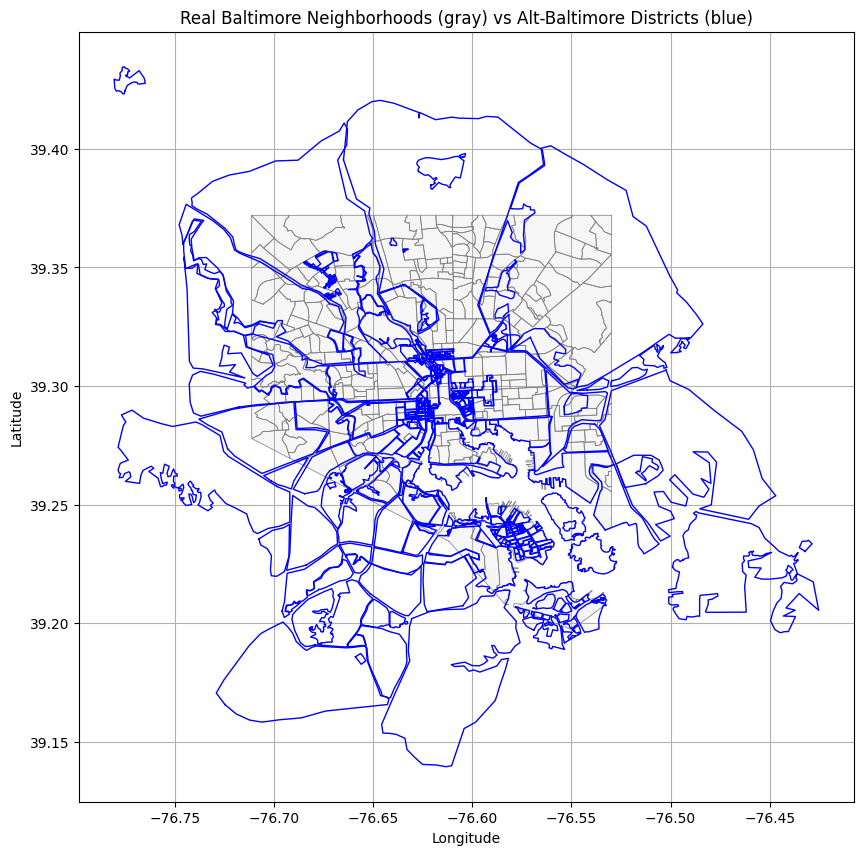

In [62]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

fig, ax = plt.subplots(figsize=(10, 10))

# --- Real neighborhoods in light gray ---
for geom in real_neighborhoods["geometry"]:
    if isinstance(geom, Polygon):
        polys = [geom]
    elif isinstance(geom, MultiPolygon):
        polys = geom.geoms
    else:
        continue
    
    for poly in polys:
        xs, ys = poly.exterior.xy
        ax.fill(xs, ys, alpha=0.2, color="lightgrey")
        ax.plot(xs, ys, color="grey", linewidth=0.5)

# --- Alt districts in blue ---
for geom in alt_polygons["geometry"]:
    if isinstance(geom, Polygon):
        polys = [geom]
    elif isinstance(geom, MultiPolygon):
        polys = geom.geoms
    else:
        continue

    for poly in polys:
        xs, ys = poly.exterior.xy
        ax.plot(xs, ys, color="blue", linewidth=1)

plt.title("Real Baltimore Neighborhoods (gray) vs Alt-Baltimore Districts (blue)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()



## 7. Interactive Map: Real vs Alt-Baltimore (Folium)

Here we overlay the official Baltimore neighborhood boundaries and the
Alt-Baltimore speculative districts on top of a web basemap using
Folium/Leaflet. This provides a visual reality check on how the imagined
districts sit within the real city.


In [63]:
import folium

# --- Helper: convert a DataFrame of Shapely geometries to a GeoJSON dict ---
def df_to_feature_collection(df, name_field="name"):
    features = []
    for _, row in df.iterrows():
        geom = row["geometry"]
        if geom is None:
            continue
        features.append({
            "type": "Feature",
            "geometry": geom.__geo_interface__,
            "properties": {name_field: row[name_field]},
        })
    return {"type": "FeatureCollection", "features": features}

# Use the already-filtered alt_polygons and real_neighborhoods
real_fc = df_to_feature_collection(real_neighborhoods, name_field="name")
alt_fc  = df_to_feature_collection(alt_polygons,       name_field="name")

# Rough map center from Alt-Baltimore centroids
alt_centroids = alt_polygons["geometry"].apply(lambda g: g.centroid)
center_lat = alt_centroids.apply(lambda p: p.y).mean()
center_lon = alt_centroids.apply(lambda p: p.x).mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles="CartoDB positron"
)

# --- Real neighborhoods layer (gray outlines) ---
folium.GeoJson(
    real_fc,
    name="Real Neighborhoods",
    style_function=lambda feature: {
        "color": "gray",
        "weight": 1,
        "fillOpacity": 0.1,
    },
    tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=["Neighborhood:"])
).add_to(m)

# --- Alt-Baltimore districts layer (blue outlines / slightly stronger fill) ---
folium.GeoJson(
    alt_fc,
    name="Alt-Baltimore Districts",
    style_function=lambda feature: {
        "color": "blue",
        "weight": 2,
        "fillOpacity": 0.25,
    },
    tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=["Alt District:"])
).add_to(m)

folium.LayerControl().add_to(m)

m
